In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from helper import *
from planarnetwork import PlanarNetwork

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import warnings
from helper import *
from planarnetwork import PlanarNetwork

class GrowingPlanarNetwork(PlanarNetwork):
    """
    Growing and shrinking rules are as follow :
    - ...
    """
        
    def index_from_coord(self, i, j, size):
        if i < 0 or j < 0 or j >= size or i >= size:
            return None
        return i * size + j
        
    # checked for size=3
    # factorisable mais osef
    def init_square(self, size=3):
        void = -1
        G = nx.Graph()
        D = nx.MultiGraph()
        D.add_node(-1)
        D.nodes[-1]["ngb"] = CircularList()  # could be a void list
        for i in range(size):
            for j in range(size):
                pass
                    
        for i in range(size):
            for j in range(size):
                this = self.index_from_coord(i, j, size)
                less = self.index_from_coord(i - 1, j - 1, size)
                dualless = self.index_from_coord(i - 1, j - 1, size - 1)
                if i < size - 1 and j < size - 1:
                    dualthis = self.index_from_coord(i, j, size - 1)
                    D.add_node(dualthis)
                    D.nodes[dualthis]["ngb"] = CircularList()
                    
                if j > 0:
                    # horizontal planar
                    target = self.index_from_coord(i, j - 1, size)
                    dualtarget = self.index_from_coord(i, j - 1, size - 1)
                    G_edge = (this, target)
                    # horizontal dual
                    if i == 0:
                        D_edge = (void, dualtarget)
                    elif i == (size - 1):
                        D_edge = (void, dualless)
                    else:
                        D_edge = (dualtarget, dualless)
                    idx = D.add_edge(*D_edge, dual=G_edge)
                    G.add_edge(*G_edge, dual=(*D_edge, idx))
                    if D_edge[0] is not None:
                        D.nodes[D_edge[0]]["ngb"].append(Ltuple((*D_edge, idx)))
                    if D_edge[1] is not None:
                        D.nodes[D_edge[1]]["ngb"].append(Ltuple((*D_edge, idx)))
                        
                if i > 0:
                    # vertical planar
                    target = self.index_from_coord(i - 1, j, size)
                    dualtarget = self.index_from_coord(i - 1, j, size - 1)
                    G_edge = (this, target)
                    # vertical dual
                    if j == 0:
                        D_edge = (void, dualtarget)
                    elif j == (size - 1):
                        D_edge = (void, dualless)
                    else:
                        D_edge = (dualtarget, dualless)
                    
                    idx = D.add_edge(*D_edge, dual=G_edge)
                    G.add_edge(*G_edge, dual=(*D_edge, idx))
                    if D_edge[0] is not None:
                        D.nodes[D_edge[0]]["ngb"].append(Ltuple((*D_edge, idx)))
                    if D_edge[1] is not None:
                        D.nodes[D_edge[1]]["ngb"].append(Ltuple((*D_edge, idx)))
                    

        # set cyclic values for all nodes
        ngbs = [(-1, 0), (0, -1), (1, 0), (0, 1)]
        for i in range(size):
            for j in range(size):
                this = self.index_from_coord(i, j, size)
                # planar
                G.nodes[this]["ngb"] = CircularList()
                for ngb in ngbs:
                    # TODO get edge instead of node
                    new = self.index_from_coord(*add((i, j), ngb), size)
                    if new is not None:
                        G.nodes[this]["ngb"].append(new)
        
        self.G = G
        self.D = D
        
    def get_intermediate_neighbours(self, node, net="planar"):
        """
        net is either 'planar' or 'dual'
        """
        cycle_pairs = self.get_cycle_pairs(node, net=net)
        return [x[0] for x in cycle_pairs]
    
    def cycle_ngb(self, circlist, from_, to_):
        """
        Returns a list from `from_` to `to_` both excluded
        """
        cur = from_
        ls = []
        while True:
            cur = circlist.next(cur)
            if cur == from_ or cur == to_:
                break
            ls.append(cur)
            
        return ls
            
    def dual_cycle_pairs(self, node):
        ngbs = self.G.nodes[node]["ngb"]
        cycle = dict()  # order is kept by ngbs
        ls_pairs = list()
        for ngb in ngbs:
            ls_pairs.append(self.G.edges[(node, ngb)]["dual"])
        ls_pairs = cycle_from_ordered_list_pairs(ls_pairs)
        self.debug(locals())
        return {ngb: pair for ngb, pair in zip(ngbs, ls_pairs)}
    
    def planar_cycle_pairs(self, node):
        ngbs = self.D.nodes[node]["ngb"]
        cycle = dict()  # order is kept by ngbs
        ls_pairs = list()
        for ngb in ngbs:
            ls_pairs.append(self.D.edges[ngb]["dual"])
        ls_pairs = cycle_from_ordered_list_pairs(ls_pairs)
        return {ngb: pair for ngb, pair in zip(ngbs, ls_pairs)}
        
    def duplicate_random_node(self):
        n = random.choice(list(self.G.nodes))
        return self.duplicate_node(n)
    
    def remove_random_node(self):
        n = random.choice(list(self.G.nodes))
        return self.remove_node(n)
    
    def set_cross_dual(self, edge_1, edge_2):
        self.set_dual(edge_1, edge_2)
        self.set_dual(edge_2, edge_1)
        
    def are_from_common_cycle(self, a, b, c):
        """
        Only for triangle cycles, otherwise it will likely raise an error 
        because of unexisting edge
        """
        common_dual = set(self.dual((a, b))[:2]) \
                              & set(self.dual((a, c))[:2]) \
                              & set(self.dual((b, c))[:2]) \
                              - {-1}
        
        return len(common_dual) == 1
    
    def duplicate_node(self, node):
        """
        High level function
        We have a graph, a dual graph, edge indexes and ngb cyclic order
        All must stay ok to prove consistence through recurrence
        
        Division step:
        A1) Split neighbours according to the cyclic order
        A1b) Construct "neighbour" dual node (intermediate graph with order)
        A2) Update edges and dual graph edges accordingly
        A3) Add inner edge with corresponding dual
        
        Compensation step:
        B1) Get previous neighbour dual node
        B2) Select dual node if #ngb > 4
        B3) For all of them, iteratively
        B4) Select pair of non-adjacent nodes with lowest degree
        B5) As for normal step, run a split neighbour + edge update + inner edge
        
        Make graphics to help understand
        """
        
        # A1
        ngbs = self.G.nodes[node]["ngb"]
        nb_ngbs = len(ngbs)
        half_1 = nb_ngbs // 2
        half_2 = nb_ngbs - half_1
        
        # A1b
        cycle_dual = self.dual_cycle_pairs(node)
        
        # A2 remove edge
        for ngb in ngbs:
            self.G.remove_edge(node, ngb)
        
        # division
        new_node = self.index("planar")
        self.G.add_node(new_node)
        split_ngb = random.choice(ngbs)
        current = split_ngb

        self.G.nodes[node]["ngb"] = CircularList()
        self.G.nodes[new_node]["ngb"] = CircularList()
        
        for i in range(half_1):
            self.G.add_edge(node, current, dual=cycle_dual[current])
            self.G.nodes[node]["ngb"].append(current)
            current = ngbs.next(current)
        self.G.nodes[node]["ngb"].append(new_node)
        
        opp_split_ngb = current
        for j in range(half_2):
            self.G.add_edge(new_node, current, dual=cycle_dual[current])
            self.D.edges[cycle_dual[current]]["dual"] = (new_node, current)
            self.G.nodes[new_node]["ngb"].append(current)
            # update ngb
            ls_to_update = self.G.nodes[current]["ngb"]
            ls_to_update[ls_to_update.index(node)] = new_node
            current = ngbs.next(current)
        self.G.nodes[new_node]["ngb"].append(node)
        
            
        # A3
        first_dual_edge = Ltuple(cycle_dual[split_ngb])
        second_dual_edge = Ltuple(cycle_dual[opp_split_ngb])

        if len(cycle_dual) >= 3:
            # implicit, nope it is not ok at all
            first_dual, second_dual = first_dual_edge[0], second_dual_edge[0]
            
        elif len(cycle_dual) == 2:
            assert min(first_dual_edge[:2]) == min(second_dual_edge[:2])
            assert max(first_dual_edge[:2]) == max(second_dual_edge[:2])
            # need to use the non -1 dual as an anchor
            first_dual, second_dual = max(first_dual_edge[:2]), min(first_dual_edge[:2])
            ref_order = self.D.nodes[first_dual]["ngb"]
            if ref_order.match_pattern([first_dual_edge, second_dual_edge]):
                pass
            
            elif ref_order.match_pattern([second_dual_edge, first_dual_edge]):
                first_dual_edge, second_dual_edge = second_dual_edge, first_dual_edge
            
            else:
                raise RuntimeError("pattern matching on dual edge did not work")
        
        idx = self.D.add_edge(first_dual, second_dual, dual=(node, new_node))
        inner_dual_edge = Ltuple((first_dual, second_dual, idx))
        self.G.add_edge(node, new_node, dual=inner_dual_edge)
        
        # keep order for dual inner
        # to do so, cycle_dual has information on the dual edges
        # so we must insert it after this one
        idx_1 = index_of(first_dual_edge, self.D.nodes[first_dual]["ngb"])
        self.D.nodes[first_dual]["ngb"].insert(idx_1 + 1, inner_dual_edge)
        idx_2 = index_of(second_dual_edge, self.D.nodes[second_dual]["ngb"])
        self.D.nodes[second_dual]["ngb"].insert(idx_2 + 1, inner_dual_edge)
        
        # B
        # stabilize cycle
        dual_list = list_from_cycle_dual(cycle_dual)
        for dual_node in dual_list:
            if self.D.degree(dual_node) > 4 and dual_node != -1:
                try:
                    self.shorten_cycle(dual_node)
                except:
                    print("debug")
                    print(locals())
                    raise
                
        return new_node
    
    def stabilize_ngb(self, node):
        ngbs = self.ngb(node)
        if len(ngbs) > 5:  # at least 6 neighbours
            # pick one node
            ls = list(map(lambda x: len(self.ngb(x)), ngbs))
            other_node = ngbs[ls.index(max(ls))]
            edge = (other_node, node)
            
            if -1 in self.dual(edge):
                self.debug({"Warn": "Stabilization tried to occur on border edge"})
                return  # avoid removing border edge
            
            self._remove_edge(edge)
            
            # shorten cycle if required
            cycle_dual = self.dual_cycle_pairs(node)
            dual_list = list_from_cycle_dual(cycle_dual)
            for dual_node in dual_list:
                if self.D.degree(dual_node) > 4 and dual_node != -1:
                    self.shorten_cycle(dual_node)
        
    def shorten_cycle(self, dual_node, source=None, target=None):  # aka Compensation Step
        """
        This function adds an edge between two opposite nodes in a cycle
        if the cycle is longer than 5, because it is not biologically plausible
        
        Compensation step:
        B1) Get previous neighbour dual node
        B2) Select dual node if #ngb > 4
        B3) For all of them, iteratively
        B4) Select pair of non-adjacent nodes with lowest degree
        B5) As for normal step, run a split neighbour + edge update + inner edge
        """
        rand_planar_ngb = self.get_intermediate_neighbours(dual_node, net="dual")
        random.shuffle(rand_planar_ngb)
        min_pair = None
        min_score = 1e6
        # B4
        for i in rand_planar_ngb:
            for j in rand_planar_ngb:
                if j <= i or (i, j) in self.G.edges:
                    continue
                score = self.G.degree(i) + self.G.degree(j)
                if score < min_score:
                    min_pair = (i, j)
                    min_score = score
                    
        return self._make_edge(dual_node, min_pair)
                    
    def _make_edge(self, dual_node, min_pair):
        # B5
        if self.verbose:
            print("Shorten", min_pair, "on", dual_node)
            
        Z = self.D.nodes[-1]["ngb"]
        
        # A1
        ngb_edges = self.D.nodes[dual_node]["ngb"]
        nb_ngbs = len(ngb_edges)
        
        
        # A1b
        map_edge_pair = self.planar_cycle_pairs(dual_node)
        
        ordered_cycle_pairs = cycle_from_ordered_list_pairs([map_edge_pair[x] for x in ngb_edges])
        
        ingbs = CircularList([x[0] for x in ordered_cycle_pairs])
        
        map_ingb_pair = {x[0]: x for x in ordered_cycle_pairs}
        
        # A2 remove edge
        for edge in ngb_edges:
            self.D.remove_edge(*edge)
        
        # division
        new_node = self.index("dual")
        self.D.add_node(new_node)
        
        split_ngb_1, split_ngb_2 = min_pair
        current = split_ngb_1

        self.D.nodes[dual_node]["ngb"] = CircularList()
        self.D.nodes[new_node]["ngb"] = CircularList()
        
        while current != split_ngb_2:
            planar_edge = map_ingb_pair[current]
            dual_edge = self.dual(planar_edge)
            
            # here id is not taken into consideration
            self.D.add_edge(*dual_edge, dual=planar_edge)
            self.D.nodes[dual_node]["ngb"].append(dual_edge)
            
            current = ingbs.next(current)
        
        
        while current != split_ngb_1:
            planar_edge = map_ingb_pair[current]
            dual_edge = self.dual(planar_edge)
            
            try:
                current_edge = self.replace_node(dual_edge, dual_node, new_node)[:2]
            except:
                print(locals())
                raise
            
            idx = self.D.add_edge(*current_edge, dual=planar_edge)
            new_edge = (*current_edge, idx)
            
            self.G.edges[planar_edge]["dual"] = new_edge
            self.D.nodes[new_node]["ngb"].append(new_edge)
            
            dual_current = self.get_other_node(dual_edge, dual_node)
            ls_to_update = self.D.nodes[dual_current]["ngb"]
            
            try:
                ls_to_update[index_of(dual_edge, ls_to_update)] = new_edge
            except:
                print(locals())
                print(self.D.nodes[-1]["ngb"], Z)
                raise
            
            current = ingbs.next(current)
        
        idx = self.D.add_edge(dual_node, new_node)
        inner_dual_edge = Ltuple((dual_node, new_node, idx))
        self.D.nodes[dual_node]["ngb"].append(inner_dual_edge)
        self.D.nodes[new_node]["ngb"].append(inner_dual_edge)
        
        self.G.add_edge(split_ngb_1, split_ngb_2, dual=inner_dual_edge)
        self.D.edges[inner_dual_edge]["dual"] = (split_ngb_1, split_ngb_2)
        
        
        idx_1 = index_of(map_ingb_pair[split_ngb_1][1], self.G.nodes[split_ngb_1]["ngb"])
        self.G.nodes[split_ngb_1]["ngb"].insert(idx_1 + 1, split_ngb_2)
        idx_2 = index_of(map_ingb_pair[split_ngb_2][1], self.G.nodes[split_ngb_2]["ngb"])
        self.G.nodes[split_ngb_2]["ngb"].insert(idx_2 + 1, split_ngb_1)
        
        return new_node
        
    def replace_node(self, edge, old, new):
        """
        This function is used to modify an edge in the "ngb" slot
        
        Example:
        We have (1, 4, 0) and we need to change the 4 by a 5
        However this function is not correct for dual edge
        """
        edge_ = list(edge)
        edge_[edge_.index(old)] = new
        return tuple(edge_)
    
    def swap_node(self, node1, node2):
        """
        We could only do a reference swap, however this makes harder the monitoring.
        Therefore we implement it
        """
        # sanity check
        assert (node1, node2) in self.G.edges, f"Trying to swap non-adjacent nodes {node1} and {node2}"
        
        ngb1, ngb2 = self.ngb(node1), self.ngb(node2)
        ngb1[ngb1.index(node2)] = node1
        ngb2[ngb2.index(node1)] = node2
        self.set_ngb(node2, ngb1)
        self.set_ngb(node1, ngb2)
        
        def ngb_update(self, nodeA, nodeB, ngbs):
            for ngb in ngbs:
                if ngb == nodeA:
                    continue
                dual_edge = self.dual((nodeA, ngb))
                self.set_dual(dual_edge, (nodeB, ngb))
                self.G.add_edge(nodeB, ngb, dual=dual_edge)
                self.G.remove_edge(nodeA, ngb)
                self.ngb(ngb).replace(nodeA, nodeB)
                
        ngb_update(self, node1, node2, ngb1)
        ngb_update(self, node2, node1, ngb2)
    
    def ngb(self, node, net="planar"):
        G = self.G if net == "planar" else self.D
        return G.nodes[node]["ngb"]
    
    def set_ngb(self, node, ngb, net="planar"):
        G = self.G if net == "planar" else self.D
        G.nodes[node]["ngb"] = CircularList(ngb)
        
    # helpers (to use at the end to simplify the code)
    def dual(self, edge):
        if len(edge) == 2:
            return self.G.edges[edge]["dual"]
        
        elif len(edge) == 3:
            return self.D.edges[edge]["dual"]
        
        else:
            raise ValueError(f"edge not recognised : {edge}")
            
    def set_dual(self, edge, dual):
        if len(edge) == 2 and len(dual) == 3:
            self.G.edges[edge]["dual"] = Ltuple(dual)
        
        elif len(edge) == 3 and len(dual) == 2:
            self.D.edges[edge]["dual"] = Ltuple(dual)
        
        else:
            raise ValueError(f"edges not recognised or did not match : {edge}, {dual}")
            
    def get_other_node(self, edge, node):
        if edge[0] == node:
            return edge[1]
        
        elif edge[1] == node:
            return edge[0]
        
        else:
            raise ValueError(f"{node} is not in {edge}")
            
    def common_dual(self, edge_1, edge_2):
        x = set(self.dual(edge_1)[:2]) & set(self.dual(edge_2)[:2]) - {-1}
        if len(x) > 1:
            raise ValueError(f"Found multiple common dual (non -1) "
                             f"{x} for edges {edge_1} and {edge_2}")
        elif len(x) == 0:
            return None  # because -1 is in common normally
        
        return list(x)[0]
            
    def check_dual_ngb_consistency(self, node):
        if node not in self.D.nodes:
            return
        
        ngb_edges = self.D.nodes[node]["ngb"]
        nb_ngbs = len(ngb_edges)
        map_edge_pair = self.planar_cycle_pairs(node)
        ordered_cycle_pairs = cycle_from_ordered_list_pairs([map_edge_pair[x] for x in ngb_edges])
        error = f"Uncorrect pattern in cycle {ordered_cycle_pairs} for node {node}"
        length = len(ordered_cycle_pairs)
        for i in range(1, length):
            self.check(ordered_cycle_pairs[i][0] == ordered_cycle_pairs[i - 1][1], error)
        self.check(ordered_cycle_pairs[0][0] == ordered_cycle_pairs[length - 1][1], error)
            
    def check_planar_ngb_consistency(self, node):
        if node not in self.G.nodes:
            return
        
        ngb_edges = self.G.nodes[node]["ngb"]
        nb_ngbs = len(ngb_edges)
        map_edge_pair = self.dual_cycle_pairs(node)
        ordered_cycle_pairs = cycle_from_ordered_list_pairs([map_edge_pair[x] for x in ngb_edges])
        error = f"Uncorrect pattern in cycle {ordered_cycle_pairs} for node {node}"
        length = len(ordered_cycle_pairs)
        for i in range(1, length):    
            self.check(ordered_cycle_pairs[i][0] == ordered_cycle_pairs[i - 1][1], error)
        self.check(ordered_cycle_pairs[0][0] == ordered_cycle_pairs[length - 1][1], error)
    
    def check_duality_consistency(self):
        for *e, d in self.G.edges(data=True):
            d_e = d["dual"]
            dd_e = self.D.edges[d_e]["dual"]
            try:
                assert Ltuple(dd_e) == Ltuple(e)
            except:
                raise ValueError(f"{dd_e} is not equal to {e} in G graph")
        
        for *e, d in self.D.edges(data=True, keys=True):
            d_e = d["dual"]
            dd_e = self.G.edges[d_e]["dual"]
            try:
                assert Ltuple(dd_e) == Ltuple(e)
            except:
                raise ValueError(f"{dd_e} is not equal to {e} in D graph")
    
    def check_ngbs_consistency(self):
        for n in self.G.nodes:
            self.check_planar_ngb_consistency(n)
            
        for n in self.D.nodes:
            if n == -1:
                continue
            self.check_dual_ngb_consistency(n)
            
    def check_deep_ngb_consistency(self):
        for n in self.G.nodes:
            cycle = self.get_cycle_pairs(n)
            if len(cycle) == 2:
                continue  # nothing to check more than in check_ngbs_consistency
            
            for i in range(len(cycle)):
                # for each pair, we must check that the common node has the same pattern
                p1, p2 = cycle[i], cycle[(i + 1) % len(cycle)]
                node = p1[1]  # also p2[0]
                if node == -1:
                    continue
                # exception for -1
                ngb_dual_node = self.ngb(node, net="dual")
                err_msg = f"Order is not correct for {n} with dual {node}. Cycle is {cycle} " \
                    f"and dual ngb is {ngb_dual_node}"
                assert ngb_dual_node.match_pattern([Ltuple(p2), Ltuple(p1)]), err_msg
                
    def check_void_doublet(self):
        ls = self.ngb(-1, net="dual")
        assert len(ls) == len(set(ls)), f"Doublets found in void ngb, {ls}"
        
    def check_void_ngbs(self):
        for e in self.D.nodes[-1]["ngb"]:
            assert e in self.D.edges, f"Error edge {e} is in ngbs of -1 but not in graph D"
                
    def check_all(self):
        self.check_duality_consistency()
        self.check_ngbs_consistency()
        self.check_deep_ngb_consistency()
        self.check_void_doublet()
        self.check_void_ngbs()
            
    def create_edge(self, source, target, ref_node=None, ref_dual_node=None):
        """
        Only for planar graph, not for dual
        """
        graph_source = self.get_intermediate_neighbours(source, net="planar")
        graph_target = self.get_intermediate_neighbours(target, net="planar")
        inter = list(set(graph_source) & set(graph_target) - set((-1,)))
        
        if len(inter) > 1:
            if ref_dual_node is not None:
                dual_node = ref_dual_node
                
            else:
                raise RuntimeError("ref_dual_node shall not be None")
                dual_node = inter[0]
                warnings.warn(f"Careful for {source} and {target} "
                             f"because their neighbour are {graph_source} and "
                             f"{graph_target}")
        
            self._make_edge(dual_node, (source, target))
            
        elif len(inter) == 0:
            self._make_border_edge(ref_node, (source, target))
            
        else:
            dual_node = inter[0]
        
            self._make_edge(dual_node, (source, target))
            
    def _remove_edge(self, edge):
        """
        1 pick dual edge
        2 rebuild ngb from both ngb and next (implicitly remove the old dual)
        3 remove from planar ngb
        4 remove + readd dual edges
        5 update duality
        6 replace in the ngb of others
        X might be ok
        TODO here -1 ngb is disrupted
        """
        # 1
        dual_edge = Ltuple(self.dual(edge))
        dual_0, dual_1, _ = dual_edge
        if dual_1 == -1:
            dual_0, dual_1 = dual_1, dual_0
        
        # 2
        ngb_0 = self.ngb(dual_0, net="dual")
        ngb_1 = self.ngb(dual_1, net="dual")
        # ls_0 = [] if (dual_0 == -1) else self.cycle_ngb(ngb_0, from_=dual_edge, to_=dual_edge)
        ls_0 = self.cycle_ngb(ngb_0, from_=dual_edge, to_=dual_edge)
        ls_1 = self.cycle_ngb(ngb_1, from_=dual_edge, to_=dual_edge)
        
        # 3
        self.G.remove_edge(*edge)
        
        # 4
        ls_1_true = []
        for i_dual_edge in ls_1:
            i_dual_node = self.get_other_node(i_dual_edge, dual_1)
            i_planar_edge = self.dual(i_dual_edge)
            self.D.remove_edge(*i_dual_edge)
            idx = self.D.add_edge(dual_0, i_dual_node)
            i_new_dual_edge = Ltuple((dual_0, i_dual_node, idx))
            self.set_cross_dual(i_new_dual_edge, i_planar_edge)
            self.ngb(i_dual_node, net="dual").replace(Ltuple(i_dual_edge),
                                                      i_new_dual_edge)
            ls_1_true.append(i_new_dual_edge)
            
        # 5
        self.D.remove_node(dual_1)
        new_dual_ngb = CircularList(ls_0 + ls_1_true)
        self.set_ngb(dual_0, new_dual_ngb, net="dual")
        
        # 6
        self.ngb(edge[0]).remove(edge[1])
        self.ngb(edge[1]).remove(edge[0])
        
        
    def remove_node(self, node):
        """
        In a remove node, we first connect all neighbours that are not
        A) for all ngb pairs, add edge if not exists
        B) effectively remove the central node
        C) shorten the central cycle
        """
        to_remove = None
        # A
        # A1
        ngbs = self.G.nodes[node]["ngb"]
        nb_ngbs = len(ngbs)
        
        # A1b
        cycle_dual = self.dual_cycle_pairs(node)
        
        if len(cycle_dual) == 2:
            # case where node is just removed
            ngbs = self.ngb(node)
            if (ngbs[0], ngbs[1]) in self.G.edges:
                self._remove_edge((ngbs[0], ngbs[1]))
            
            self._quick_remove(node)
                
            return
        
        # create connections between its neighbours
        for i in range(nb_ngbs):
            n_a, n_b = ngbs[i], ngbs[(i + 1) % nb_ngbs]
            
            # keep not linked if border
            if (-1 in self.get_intermediate_neighbours(n_a)) \
                and (-1 in self.get_intermediate_neighbours(n_b)):
                to_remove = (n_a, n_b)

            if not (n_a, n_b) in self.G.edges:
                ref_dual_node = self.common_dual((node, n_a), (node, n_b))
                self.create_edge(n_a, n_b, ref_dual_node=ref_dual_node, ref_node=node)
                
            # if edge but dual is not correct
            elif not self.are_from_common_cycle(node, n_a, n_b):
                self._remove_edge((n_a, n_b))
                ref_dual_node = self.common_dual((node, n_a), (node, n_b))
                self.create_edge(n_a, n_b, ref_dual_node=ref_dual_node, ref_node=node)
            
        
        if to_remove:
            self._remove_edge(to_remove)
        
        # compensation step
        for ngb in ngbs:
            self.stabilize_ngb(ngb)
        
    def _quick_remove(self, node):
        assert self.G.degree(node) == 2, f"Illegal call of _quick_remove for node {node}"
        """
        Things to do are :
        -1 create a naked edge between neighbours
        -2 remove a random dual edge among the two available
        -3 remove old planar edges
        -4 remove node
        -5 reset duality in naked planar edge and keeped dual edge
        -6 update planar ngb (replace)
        -7 update dual ngb (remove)
        """
        # 1
        ngbs = self.ngb(node)
        self.G.add_edge(ngbs[0], ngbs[1])
        
        # 2
        keeped_dual_edge = self.dual((node, ngbs[0]))
        removed_dual_edge = self.dual((node, ngbs[1]))
        self.D.remove_edge(*removed_dual_edge)
        
        # 3
        self.G.remove_edge(node, ngbs[0])
        self.G.remove_edge(node, ngbs[1])
        
        # 4
        self.G.remove_node(node)
        
        # 5
        self.set_dual((ngbs[0], ngbs[1]), keeped_dual_edge)
        self.set_dual(keeped_dual_edge, (ngbs[0], ngbs[1]))
        
        # 6
        self.ngb(ngbs[0]).replace(node, ngbs[1])
        self.ngb(ngbs[1]).replace(node, ngbs[0])
        
        # 7
        self.ngb(removed_dual_edge[0], net="dual").remove(removed_dual_edge)
        self.ngb(removed_dual_edge[1], net="dual").remove(removed_dual_edge)
        
    def _make_border_edge(self, node, min_pair):
        dual_node = -1
        # B5
        if self.verbose:
            print("Shorten", min_pair, "on", dual_node)
        
        
        # A2 remove edge
        crossing_pairs = [(node, min_pair[0]), (node, min_pair[1])]
        self.D.remove_edge(*self.dual(crossing_pairs[0]))
        self.D.remove_edge(*self.dual(crossing_pairs[1]))
        
        # division
        new_node = self.index("dual")
        self.D.add_node(new_node)
        
        split_ngb_1, split_ngb_2 = min_pair
        current = split_ngb_1

        # self.D.nodes[dual_node]["ngb"] = CircularList()
        self.D.nodes[new_node]["ngb"] = CircularList()
        
        # set up correct order
        ngb = self.ngb(node)
        if ngb.match_pattern(min_pair):
            crossing_pairs = crossing_pairs[::-1]
            split_ngb_1, split_ngb_2 = split_ngb_2, split_ngb_1
        
        elif ngb.match_pattern(min_pair[::-1]):
            pass
        
        else:
            raise ValueError(f"No match for {ngb} and {crossing_pairs}")
            
        for current, planar_edge in zip(min_pair, crossing_pairs):
            # planar_edge = map_ingb_pair[current]
            dual_edge = self.dual(planar_edge)
            
            current_edge = self.replace_node(dual_edge, dual_node, new_node)[:2]
            
            idx = self.D.add_edge(*current_edge, dual=planar_edge)
            new_edge = (*current_edge, idx)
            
            self.G.edges[planar_edge]["dual"] = new_edge
            self.D.nodes[new_node]["ngb"].append(new_edge)
            
            dual_current = self.get_other_node(dual_edge, dual_node)
            ls_to_update = self.D.nodes[dual_current]["ngb"]
            
            ls_to_update[index_of(dual_edge, ls_to_update)] = new_edge
            # shouldn't we remove the ngb of -1 ??
            self.ngb(-1, net="dual").remove(Ltuple(dual_edge))
        
        idx = self.D.add_edge(dual_node, new_node)
        inner_dual_edge = Ltuple((dual_node, new_node, idx))
        self.D.nodes[dual_node]["ngb"].append(inner_dual_edge)
        self.D.nodes[new_node]["ngb"].append(inner_dual_edge)  # not ok
        # need to define the right order in the for loop THERE
        
        self.G.add_edge(split_ngb_1, split_ngb_2, dual=inner_dual_edge)
        self.D.edges[inner_dual_edge]["dual"] = (split_ngb_1, split_ngb_2)
        
        # knowing the right order, there will be one next and one previous THERE
        idx_1 = index_of(crossing_pairs[0][0], self.G.nodes[split_ngb_1]["ngb"])
        self.G.nodes[split_ngb_1]["ngb"].insert(idx_1 + 1, split_ngb_2)  # to check
        idx_2 = index_of(crossing_pairs[1][0], self.G.nodes[split_ngb_2]["ngb"])
        self.G.nodes[split_ngb_2]["ngb"].insert(idx_2, split_ngb_1)  # to check
        
        return new_node
        
    def _remove_node(self, node):
        ingbs = self.get_intermediate_neighbours(node, net="planar")
        ngbs = self.G.nodes[node]["ngb"]
        # create a function that reconstruct the future "ngb" of the merged node
        new_ingbs, old_edges = self._get_merged_neighbours(node, ingbs)
        
        for ngb in ngbs:
            self.G.nodes[ngb]['ngb'].remove(node)
            
        self.G.remove_node(node)
        
        # create this new merged node, remove others and change names in other "ngb"
        # arbitrarily take the highest index (also prevent taking -1)
        keeped_dual = min(ingbs)
                
        # add edges to get their id
        keeped_dual_new_ngb = CircularList()
        
        for new_ingb, old_edge in zip(new_ingbs, old_edges):
            idx = self.D.add_edge(keeped_dual, new_ingb)
            new_edge = (keeped_dual, new_ingb, idx)
            keeped_dual_new_ngb.append(new_edge)
            
            # dual edge update
            dual_edge = self.D.edges[old_edge]["dual"]
            self.D.edges[new_edge]["dual"] = dual_edge
            self.G.edges[dual_edge]["dual"] = new_edge
        
            # replace in "ngb"
            self.D.nodes[new_ingb]["ngb"].replace(Ltuple(old_edge), Ltuple(new_edge))
            
            # remove old edge
            self.D.remove_edge(*old_edge)
        
        if keeped_dual == -1:
            # add new edges to -1
            self.D.nodes[keeped_dual]["ngb"] += keeped_dual_new_ngb
            # remove edges with nodes that does not exist anymore
            self._remove_edges_with(keeped_dual, ingbs)
        else:
            self.D.nodes[keeped_dual]["ngb"] = keeped_dual_new_ngb
        
        for node in ingbs:
            if node != keeped_dual:
                self.D.remove_node(node)
                
    def _remove_edges_with(self, node, ngbs):
        """
        Only for dual graph for now
        """
        ngbs = set(ngbs) - {node}
        new_list = CircularList()
        for ngb in self.D.nodes[node]["ngb"]:
            if ngb[0] in ngbs or ngb[1] in ngbs:
                continue
            new_list.append(ngb)
            
        self.D.nodes[node]["ngb"] = new_list
        
    def _get_merged_neighbours(self, node, ingbs):
        # sanity check
        for ingb in ingbs:
            deg = self.D.degree(ingb)
            assert deg == 3 or ingb == -1, f"error for degree {deg}, node {node}, ingb {ingb}"
            
        new_ingbs = CircularList([])
        old_edges = CircularList([])
            
        def get_stranger(raw_ngbs, ref_ngb):
            for x in raw_ngbs:
                for y in x[:2]:
                    if y not in ref_ngb:
                        return y, x
            raise RuntimeError("Unable to find another node")
            
        for ingb in ingbs:
            if ingb == -1:
                continue
            raw_ngbs = self.D.nodes[ingb]["ngb"]
            stranger, edge = get_stranger(raw_ngbs, ingbs)
            new_ingbs.append(stranger)
            old_edges.append(edge)
            
        return new_ingbs, old_edges
    
    def get_cycle_pairs(self, node, net="planar"):
        G = self.G if net == "planar" else self.D
        ngb_edges = G.nodes[node]["ngb"]
        nb_ngbs = len(ngb_edges)
        
        if net == "planar":
            map_edge_pair = self.dual_cycle_pairs(node)
        else:
            map_edge_pair = self.planar_cycle_pairs(node)

        ordered_cycle_pairs = cycle_from_ordered_list_pairs([map_edge_pair[x] for x in ngb_edges])
        return ordered_cycle_pairs

In [37]:
if False:
    from gpn2 import GrowingPlanarNetwork as GrowingPlanarNetwork2
    import random
    import numpy as np

In [1]:
random.seed(0)
np.random.seed(0)
gpn = GrowingPlanarNetwork()
gpn.init_square()
gpn.duplicate_node(6)

NameError: name 'random' is not defined

merged debug 1 [4, 6, 3, 5]
<<< [(6, 4, 0), (4, 5, 0), (4, -1, 0)] [4, 6, 3, 5] 4
>>> -1 (4, -1, 0) 4
<<< [(6, 3, 0), (6, 4, 0), (2, 6, 0)] [4, 6, 3, 5] 6
>>> 2 (2, 6, 0) 6
<<< [(6, 3, 0), (3, -1, 0), (5, 3, 0)] [4, 6, 3, 5] 3
>>> -1 (3, -1, 0) 3
<<< [(5, 4, 0), (5, 3, 0), (5, -1, 0)] [4, 6, 3, 5] 5
>>> -1 (5, -1, 0) 5
merged ngbs [-1, 2, -1, -1] [(4, -1, 0), (2, 6, 0), (3, -1, 0), (5, -1, 0)]
(2, 3) {'dual': (3, -1, 3)}
(2, 5) {'dual': (3, -1, 2)}
(3, 4) {'dual': (3, -1, 1)}
(4, 6) {'dual': (-1, 2, 1)}
(4, 5) {'dual': (3, 2, 0)}
(5, 6) {'dual': (-1, 2, 0)}
2 {'ngb': [3, 5]}
3 {'ngb': [4, 2]}
4 {'ngb': [6, 5, 3]}
5 {'ngb': [2, 4, 6]}
6 {'ngb': [5, 4]}
(-1, 3, 1) {'dual': (3, 4)}
(-1, 3, 2) {'dual': (5, 2)}
(-1, 3, 3) {'dual': (2, 3)}
(-1, 2, 1) {'dual': (4, 6)}
(-1, 2, 0) {'dual': (6, 5)}
(2, 3, 0) {'dual': (4, 5)}
-1 {'ngb': [(3, -1, 2), (3, -1, 3), (3, -1, 1), (-1, 2, 0), (-1, 2, 1)]}
2 {'ngb': [(-1, 2, 1), (-1, 2, 0), (3, 2, 0)]}
3 {'ngb': [(3, -1, 1), (3, 2, 0), (3, -1, 2), (3, -1,

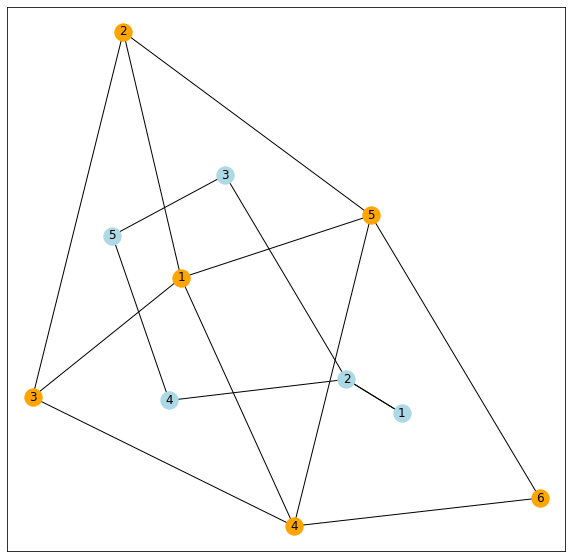

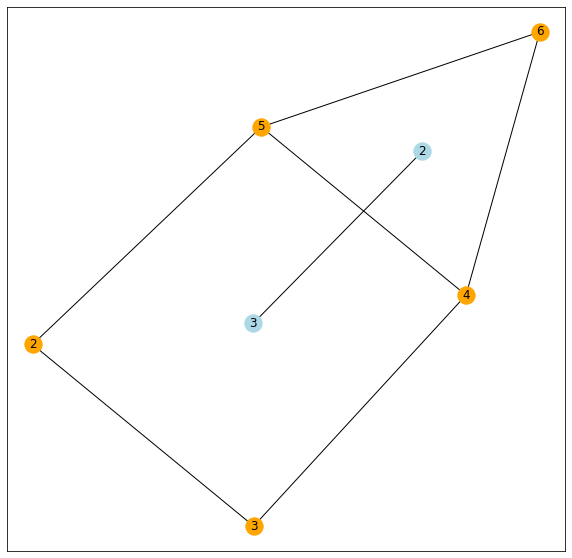

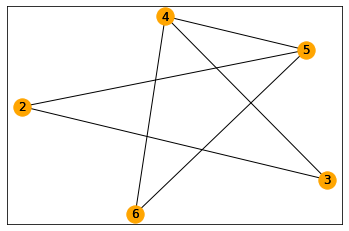

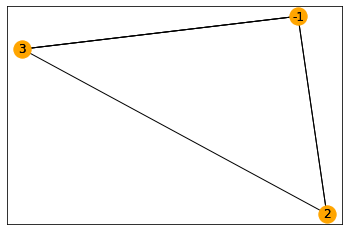

In [39]:
# add nodes
# add edges
# add duality
# add ngbs
gpn = GrowingPlanarNetwork()
gpn.G.add_nodes_from([1, 2, 3, 4, 5, 6])
gpn.D.add_nodes_from([-1, 1, 2, 3, 4, 5])

list_planar_edges = [(1, 2), (1, 3), (1, 4), (1, 5),
                      (2, 3), (3, 4), (4, 5), (5, 2),
                      (5, 6), (4, 6)]
list_dual_edges = [(3, 5, 0), (4, 5, 0), (2, 4, 0), (2, 3, 0),
                      (-1, 5, 0), (-1, 4, 0), (-1, 1, 0), (-1, 3, 0),
                      (1, 2, 0), (1, 2, 1)]

gpn.G.add_edges_from(list_planar_edges)
gpn.D.add_edges_from(list_dual_edges)

for pl, du in zip(list_planar_edges, list_dual_edges):
    gpn.G.edges[pl]["dual"] = du
    gpn.D.edges[du]["dual"] = pl
    
# individually set ngb
gpn.G.nodes[1]["ngb"] = CircularList([4, 5, 2, 3])
gpn.G.nodes[2]["ngb"] = CircularList([3, 1, 5])
gpn.G.nodes[3]["ngb"] = CircularList([4, 1, 2])
gpn.G.nodes[4]["ngb"] = CircularList([5, 6, 1, 3])
gpn.G.nodes[5]["ngb"] = CircularList([2, 1, 6, 4])
gpn.G.nodes[6]["ngb"] = CircularList([5, 4])

gpn.D.nodes[-1]["ngb"] = CircularList(list(map(Ltuple, [(-1, 5, 0), (-1, 4, 0), (-1, 1, 0), (-1, 3, 0)])))
gpn.D.nodes[1]["ngb"] = CircularList(list(map(Ltuple, [(-1, 1, 0), (2, 1, 0), (2, 1, 1)])))
gpn.D.nodes[2]["ngb"] = CircularList(list(map(Ltuple, [(2, 1, 1), (2, 1, 0), (3, 2, 0), (4, 2, 0)])))
gpn.D.nodes[3]["ngb"] = CircularList(list(map(Ltuple, [(3, 2, 0), (3, -1, 0), (5, 3, 0)])))
gpn.D.nodes[4]["ngb"] = CircularList(list(map(Ltuple, [(4, 2, 0), (4, 5, 0), (4, -1, 0)])))
gpn.D.nodes[5]["ngb"] = CircularList(list(map(Ltuple, [(5, 4, 0), (5, 3, 0), (5, -1, 0)])))

gpn.check_all()
gpn.show_all()
gpn.remove_node(1)
gpn.check_all()
gpn.show_all()
gpn.debug_all()

AssertionError: 

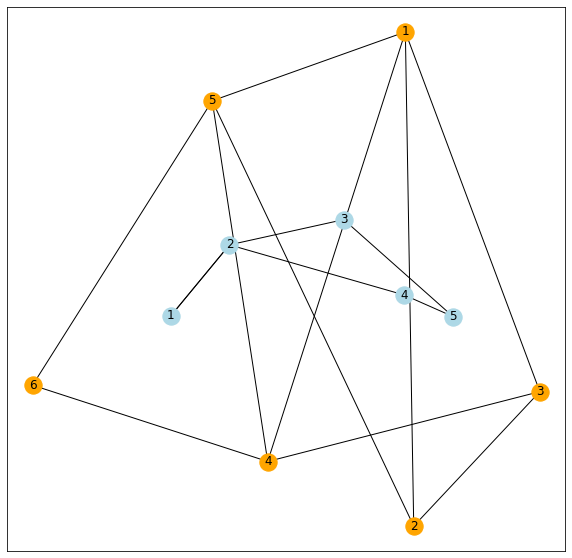

merged debug 4 [7, 4, 5, 6]
<<< [(7, 4, 0), (6, 7, 0), (1, 7, 0)] [7, 4, 5, 6] 7
>>> 1 (1, 7, 0) 7
<<< [(5, 4, 0), (7, 4, 0), (0, 4, 0)] [7, 4, 5, 6] 4
>>> 0 (0, 4, 0) 4
<<< [(6, 5, 0), (5, 4, 0), (2, 5, 0)] [7, 4, 5, 6] 5
>>> 2 (2, 5, 0) 5
<<< [(6, 7, 0), (6, 5, 0), (3, 6, 0)] [7, 4, 5, 6] 6
>>> 3 (3, 6, 0) 6
merged ngbs [1, 0, 2, 3] [(1, 7, 0), (0, 4, 0), (2, 5, 0), (3, 6, 0)]
(1, 0) {'dual': (-1, 0, 0)}
(1, 2) {'dual': (-1, 1, 0)}
(1, 3) {'dual': (4, 0, 1)}
(1, 5) {'dual': (4, 1, 0)}
(0, 3) {'dual': (-1, 0, 1)}
(2, 5) {'dual': (-1, 1, 1)}
(3, 6) {'dual': (-1, 2, 0)}
(3, 7) {'dual': (4, 2, 0)}
(5, 8) {'dual': (-1, 3, 1)}
(5, 7) {'dual': (4, 3, 0)}
(6, 7) {'dual': (-1, 2, 1)}
(7, 8) {'dual': (-1, 3, 0)}
1 {'ngb': [0, 3, 5, 2]}
0 {'ngb': [3, 1]}
2 {'ngb': [1, 5]}
3 {'ngb': [0, 6, 7, 1]}
5 {'ngb': [2, 1, 7, 8]}
6 {'ngb': [3, 7]}
7 {'ngb': [3, 6, 8, 5]}
8 {'ngb': [5, 7]}
(-1, 0, 0) {'dual': (1, 0)}
(-1, 0, 1) {'dual': (0, 3)}
(-1, 2, 0) {'dual': (3, 6)}
(-1, 2, 1) {'dual': (6, 7)}
(-1, 3

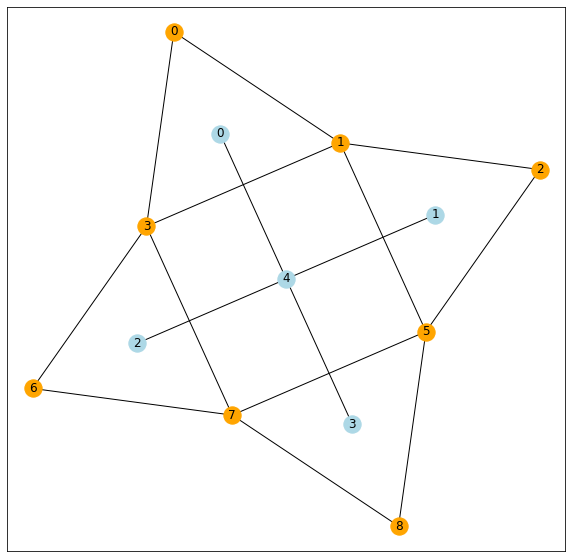

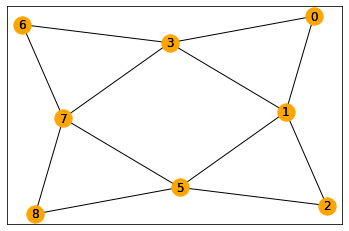

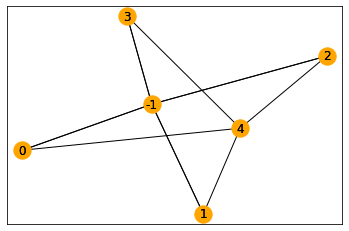

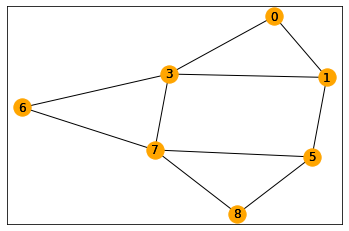

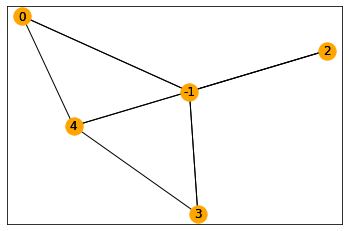

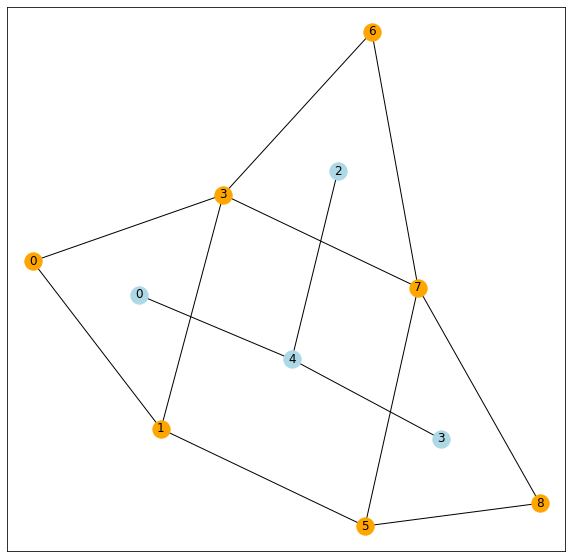

In [5]:
seed = 5
random.seed(seed), np.random.seed(seed)
gpn = GrowingPlanarNetwork()
gpn.init_square(3)
gpn.remove_node(4)
gpn.show_all()
gpn.debug_all()
gpn.remove_node(2)
# gpn._remove_edge((1, 5))
gpn.debug_all()
gpn.check_all()
gpn.show_all()

creating edge for 0 6
(0, 6) [(3, 0), (3, 6)]
creating edge for 8 2
(8, 2) [(5, 8), (5, 2)]
GG3


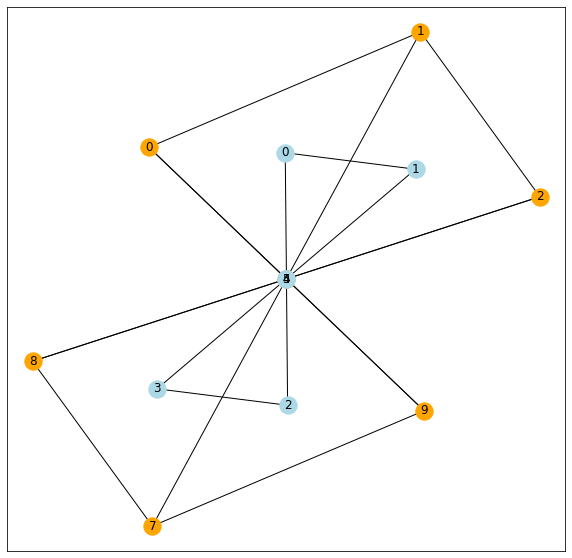

In [79]:
seed = 5
random.seed(seed), np.random.seed(seed)
gpn = GrowingPlanarNetwork2()
gpn.init_square(3)
gpn.remove_node(3)
gpn.remove_node(5)
gpn.duplicate_node(6)
gpn.remove_node(6)
gpn.show_all()

In [56]:
def prev():
    gpn = GrowingPlanarNetwork()
    gpn.init_square(3)
    gpn.check_all()
    gpn.duplicate_node(6)
    gpn.check_all()
    gpn.duplicate_node(7)
    gpn.check_all()
    gpn.remove_node(9, debug=False)

    gpn.check_all()
    gpn.remove_node(10)
    gpn.check_all()
    gpn.duplicate_node(0)
    gpn.check_all()
    gpn.duplicate_node(2)
    gpn.check_all()
    gpn.duplicate_node(3)
    gpn.check_all()
    gpn.duplicate_node(4)
    gpn.check_all()
    gpn.duplicate_node(5)
    gpn.check_all()
    gpn.duplicate_node(1)
    gpn.check_all()
    gpn.duplicate_node(7)
    gpn.check_all()
    gpn.duplicate_node(8)
    gpn.check_all()
    gpn.remove_node(9)
    gpn.check_all()
    gpn.remove_node(7, debug=False)

    gpn.check_all()
    gpn.duplicate_node(2)
    gpn.duplicate_node(3)
    gpn.duplicate_node(5)
    gpn.duplicate_node(11)
    gpn.duplicate_node(12)
    gpn.duplicate_node(13)
    gpn.duplicate_node(15)
    gpn.check_all()
    return gpn

creating edge for 3 6
merged debug 9 [7, 6, 4, 5]
<<< [(7, 6, 0), (7, 5, 0), (2, 7, 0)] [7, 6, 4, 5] 7
>>> 2 (2, 7, 0) 7
<<< [(4, 6, 0), (7, 6, 0), (-1, 6, 0)] [7, 6, 4, 5] 6
>>> -1 (-1, 6, 0) 6
<<< [(4, 6, 0), (-1, 4, 1), (5, 4, 0)] [7, 6, 4, 5] 4
>>> -1 (-1, 4, 1) 4
<<< [(5, 4, 0), (-1, 5, 0), (7, 5, 0)] [7, 6, 4, 5] 5
>>> -1 (-1, 5, 0) 5
merged ngbs [2, -1, -1, -1] [(2, 7, 0), (-1, 6, 0), (-1, 4, 1), (-1, 5, 0)]
merged debug 10 [-1, 4]
<<< [(4, -1, 3), (4, -1, 4), (4, 5, 0)] [-1, 4] 4
>>> 5 (4, 5, 0) 4
merged ngbs [5] [(4, 5, 0)]
merged debug 9 [-1, 6]
<<< [(-1, 6, 0), (6, -1, 1), (8, 6, 0)] [-1, 6] 6
>>> 8 (8, 6, 0) 6
merged ngbs [8] [(8, 6, 0)]
creating edge for 6 15
merged debug 7 [12, 13, 14, 15]
<<< [(8, 12, 0), (12, 13, 0), (15, 12, 0)] [12, 13, 14, 15] 12
>>> 8 (8, 12, 0) 12
<<< [(13, 14, 0), (12, 13, 0), (5, 13, 0)] [12, 13, 14, 15] 13
>>> 5 (5, 13, 0) 13
<<< [(15, 14, 0), (13, 14, 0), (-1, 14, 0)] [12, 13, 14, 15] 14
>>> -1 (-1, 14, 0) 14
<<< [(15, 12, 0), (15, 14, 0), (2, 

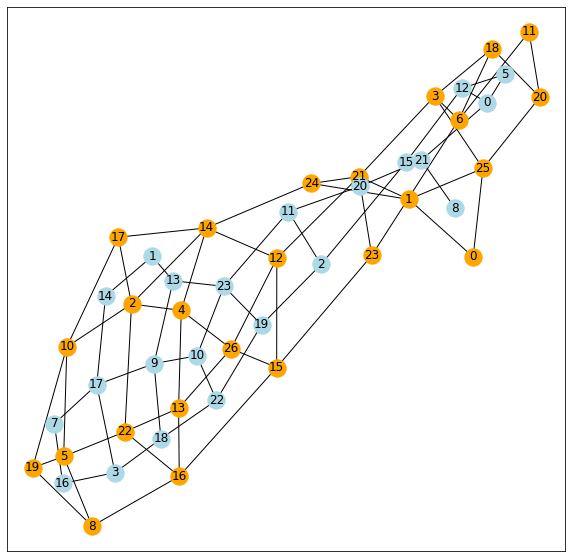

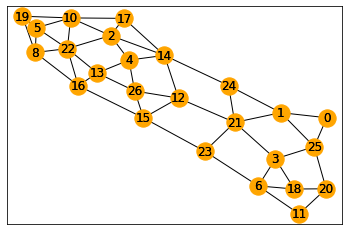

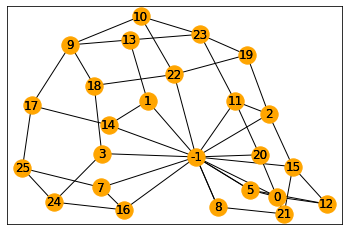

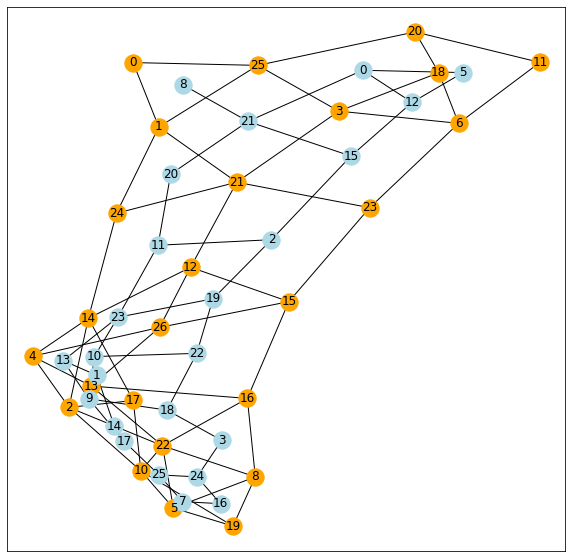

In [57]:
random.seed(0)
np.random.seed(0)
gpn = prev()
gpn.duplicate_node(1)
gpn.duplicate_node(0)
gpn.duplicate_node(4)
gpn.check_all()
gpn.show_all()
# gpn.debug_all()
gpn.remove_node(5, debug=True)
gpn.check_all()

In [52]:
x = gpn.get_cycle_pairs(5)
y = [a[0] for a in x]
x, y

([(25, 24, 0), (24, 16, 0), (16, 7, 0), (7, 25, 0)], [25, 24, 16, 7])

In [49]:
gpn.get_intermediate_neighbours(5)

TRACKING [24, 25, 24, 16, 7, 16, 7, 25]


[24, 25, 16, 7]

3 6
creating edge for 3 6
6 10
10 7
7 3
merged debug 9 [7, 6, 4, 5]
<<< [(7, 6, 0), (7, 5, 0), (2, 7, 0)] [7, 6, 4, 5] 7
>>> 2 (2, 7, 0) 7
<<< [(4, 6, 0), (7, 6, 0), (-1, 6, 0)] [7, 6, 4, 5] 6
>>> -1 (-1, 6, 0) 6
<<< [(4, 6, 0), (-1, 4, 1), (5, 4, 0)] [7, 6, 4, 5] 4
>>> -1 (-1, 4, 1) 4
<<< [(5, 4, 0), (-1, 5, 0), (7, 5, 0)] [7, 6, 4, 5] 5
>>> -1 (-1, 5, 0) 5
merged ngbs [2, -1, -1, -1] [(2, 7, 0), (-1, 6, 0), (-1, 4, 1), (-1, 5, 0)]
6 7
7 6
merged debug 10 [4, -1]
<<< [(4, -1, 3), (4, -1, 4), (4, 5, 0)] [4, -1] 4
>>> 5 (4, 5, 0) 4
merged ngbs [5] [(4, 5, 0)]
1 0
0 1
merged debug 9 [-1, 6]
<<< [(-1, 6, 0), (6, -1, 1), (8, 6, 0)] [-1, 6] 6
>>> 8 (8, 6, 0) 6
merged ngbs [8] [(8, 6, 0)]
(1, 0) {'dual': (-1, 8, 0)}
(1, 14) {'dual': (-1, 11, 0)}
(1, 12) {'dual': (8, 11, 0)}
(0, 11) {'dual': (0, -1, 1)}
(0, 3) {'dual': (0, 8, 0)}
(2, 10) {'dual': (7, -1, 1)}
(2, 4) {'dual': (1, 9, 0)}
(2, 13) {'dual': (7, 9, 0)}
(2, 14) {'dual': (1, -1, 0)}
(3, 11) {'dual': (5, 0, 0)}
(3, 12) {'dual': (8, 12,

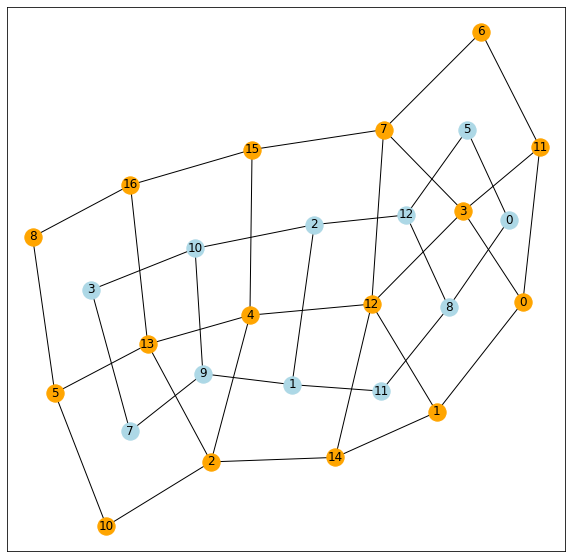

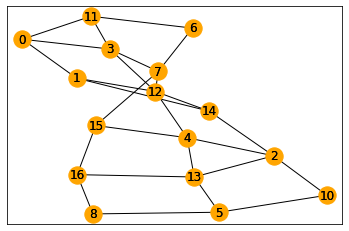

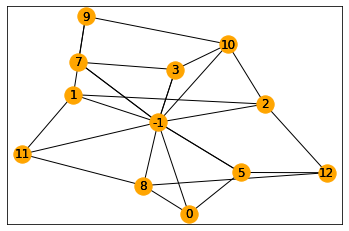

In [6]:
random.seed(0)
np.random.seed(0)
gpn = GrowingPlanarNetwork()
gpn.init_square(3)
gpn.check_all()
gpn.duplicate_node(6)
gpn.check_all()
gpn.duplicate_node(7)
gpn.check_all()
gpn.remove_node(9)
gpn.check_all()
gpn.remove_node(10)
gpn.check_all()
gpn.duplicate_node(0)
gpn.check_all()
gpn.duplicate_node(2)
gpn.check_all()
gpn.duplicate_node(3)
gpn.check_all()
gpn.duplicate_node(4)
gpn.check_all()
gpn.duplicate_node(5)
gpn.check_all()
gpn.duplicate_node(1)
gpn.check_all()
gpn.duplicate_node(7)
gpn.check_all()
gpn.duplicate_node(8)
gpn.check_all()
gpn.remove_node(9)
gpn.check_all()
gpn.show_all()
gpn.debug_all()
gpn.remove_node(7)

# gpn.show_all()
# gpn.debug_all()
gpn.check_all()
gpn.duplicate_node(6)

In [ ]:
def cycle_unique(x):
    return x

x = [24, 25, 24, 16, 7, 16, 7, 25]

cycle_unique(x)

In [4]:
"""
merged debug 9 [6, -1, 4, 5]
<<< [(6, -1, 0), (6, 5, 0), (2, 6, 0)] [6, -1, 4, 5] 6
>>> 2 (2, 6, 0) 6
<<< [(4, -1, 0), (-1, 4, 1), (5, 4, 0)] [6, -1, 4, 5] 4
"""

'\nmerged debug 9 [6, -1, 4, 5]\n<<< [(6, -1, 0), (6, 5, 0), (2, 6, 0)] [6, -1, 4, 5] 6\n>>> 2 (2, 6, 0) 6\n<<< [(4, -1, 0), (-1, 4, 1), (5, 4, 0)] [6, -1, 4, 5] 4\n'

In [5]:
gpn.get_intermediate_neighbours(7, net="planar")

KeyError: 7

In [ ]:
def get_intermediate_neighbours(self, G, node, net="planar"):
    ls_inter = list()
    ngbs = G.nodes[node]["ngb"]
    for ngb in ngbs:
        if net == "planar":
            ls_inter += list(G.edges[(node, ngb)]["dual"][:2])
        else:
            ls_inter += list(G.edges[ngb]["dual"][:2])
            
    print(ls_inter)

    return unique(ls_inter)

In [ ]:
get_intermediate_neighbours(None, gpn.G, 7)

In [ ]:
def unique_keep_order(ls):
    new_ls = []
    for x in ls:
        if x not in new_ls:
            new_ls.append(x)
    return new_ls

In [ ]:
ls = [14, 13, 4, 13, 12, 4, 14, 12]
print(unique(ls))
print(unique_keep_order(ls))

In [ ]:
for *x, y in gpn.D.edges(data=True, keys=True):
    print(x, y)

In [ ]:
random.seed(0)
GPN = GrowingPlanarNetwork()
GPN.init_square()
# GPN.create_edge(0, 4)
GPN.remove_node(4)
GPN.show_all()

In [ ]:
def cycle_from_ordered_list_pairs(ls_p):
    """
    The case where len(ls_p) == 2 is not handled
    How to know which one is the first ?
    Let's say it doesn't matter
    """
    if len(ls_p) == 2:
        return cycle_two_pairs(ls_p)
    
    ls = list(map(list, ls_p))
    if ls[0][0] in ls[1][:2]:
        ls[0][0], ls[0][1] = ls[0][1], ls[0][0]
        
    for i in range(1, len(ls)):
        if ls[i][1] in ls[i - 1]:
            ls[i][0], ls[i][1] = ls[i][1], ls[i][0]
            
    # sanity check
    for i in range(1, len(ls)):
        assert ls[i][0] == ls[i - 1][1]
            
    return list(map(tuple, ls))

In [ ]:
ngb_edges = [(4, -1, 1), (4, -1, 2), (4, 11, 0), (-1, 4, 3), (4, 5, 0)]
map_edge_pair = {(4, -1, 1): (4, 15), (4, -1, 2): (15, 6), (4, 11, 0): (17, 3), (-1, 4, 3): (17, 6), (4, 5, 0): (4, 3)}
inp = [map_edge_pair[x] for x in ngb_edges]
cycle_from_ordered_list_pairs(inp)

In [ ]:
random.seed(0)
GPN = GrowingPlanarNetwork()
GPN.init_square()
# GPN.show_all()
# GPN.duplicate_random_node()
GPN.duplicate_node(4)
# plt.figure()
# GPN.show_all()
for i in range(400):
    print(i, end="")
    GPN.duplicate_random_node()
    GPN.check_dual_ngb_consistency(77)
    
# plt.figure(figsize=(10, 10))
# GPN.show_all()
# GPN.check_dual_ngb_consistency(77)
# GPN.verbose = True
# GPN.duplicate_random_node()

In [ ]:
plt.figure(figsize=(40, 40))
GPN.show_all(k=0.2, iterations=500)

In [ ]:
list(GPN.G.neighbors(14)), GPN.G.nodes[14], GPN.G.nodes[13]

Notes

Considering that our developmental model is ok (I think that heterogeneity in division location can lead to something quite unexpected, we'll see.

However, the next step is to build simple equation.

In [ ]:
def test_square():
    GPN = GrowingPlanarNetwork()
    GPN.init_square()
    # test edge planar graph
    
    # test edge dual graph
    
    # test cyclic order planar
    
    # test cyclic order dual
    
    # test intermediate